# Semi Supervised GAN

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import os

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, img_channels = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 16, 4, 1, 0),
            self.gen_block(hidden_dim*16, hidden_dim*8, 4, 2, 1),
            self.gen_block(hidden_dim*8, hidden_dim*4, 4, 2, 1),
            self.gen_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_dim*2, 1, kernel_size =4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, noise):
        return self.gen(noise)

In [3]:
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim, 1, 1).to('cuda')

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, hidden_dim = 64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, hidden_dim, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            self.disc_block(hidden_dim, hidden_dim * 2, 4, 2, 1),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, 4, 2, 1),
            self.disc_block(hidden_dim * 4, hidden_dim * 8, 4, 2, 1), # 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Conv2d(hidden_dim * 8, 10, kernel_size = 4, stride = 2, padding = 0), 
            nn.Softmax(dim = 1)
        )
        
        self.adversary = nn.Sequential(
           nn.Conv2d(hidden_dim * 8, 1, kernel_size = 4, stride = 2, padding = 0), # 1x1
           nn.Sigmoid() 
        )
    
    def disc_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2)
        )    
    
    def forward(self, img):
        img_out = self.disc(img)
        class_pred = self.classifier(img_out)
        fake_or_real = self.adversary(img_out)
        return class_pred, fake_or_real

In [5]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [6]:
z_dim = 100
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    FashionMNIST('.', download = False, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

In [7]:
criterion = nn.BCELoss()
criterion2 = torch.nn.CrossEntropyLoss()

gen = Generator(z_dim, 1, 64).to(device)
init_weights(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))

disc = Discriminator(1, 64).to(device)
init_weights(disc)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

In [8]:
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epochs: 0 Step: 500 Generator loss: 4.730748403429985, discriminator loss: 1.1480249013900756


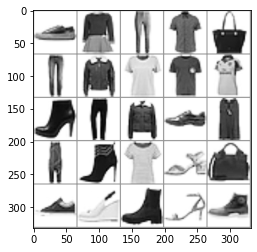

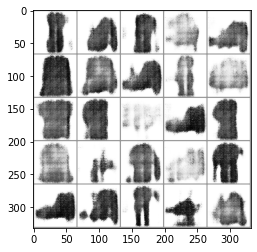

Epochs: 1 Step: 1000 Generator loss: 1.6024856522083282, discriminator loss: 1.2591192507743836


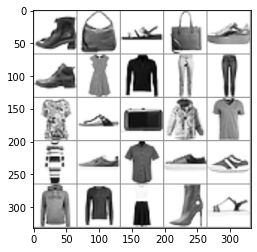

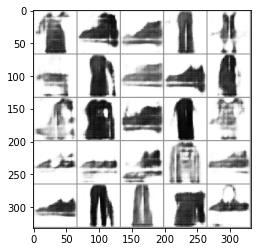

Epochs: 1 Step: 1500 Generator loss: 1.935669390439987, discriminator loss: 1.2249109687805175


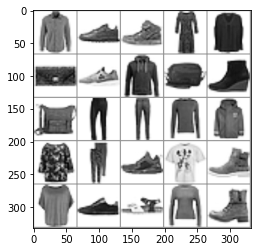

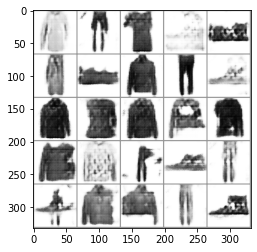

Epochs: 2 Step: 2000 Generator loss: 2.5705448254346845, discriminator loss: 1.1670107553005218


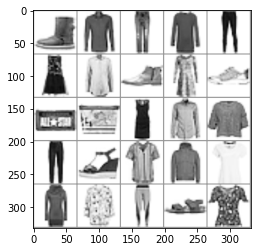

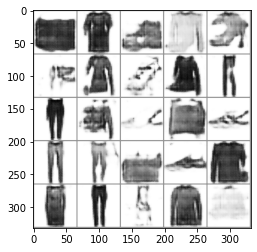

Epochs: 2 Step: 2500 Generator loss: 2.9578758670091627, discriminator loss: 1.1390153027772902


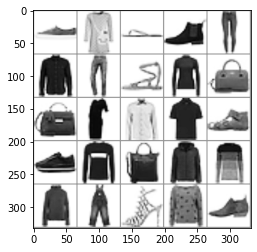

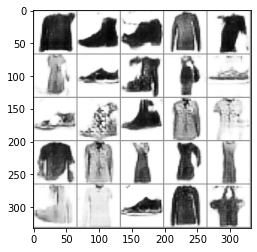

Epochs: 3 Step: 3000 Generator loss: 3.443803197860718, discriminator loss: 1.1008477795124054


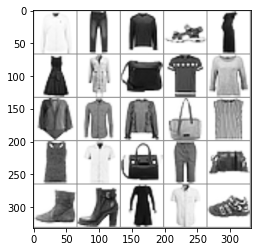

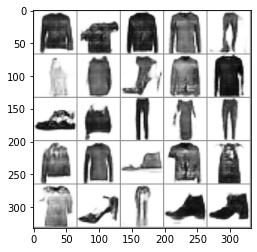

Epochs: 3 Step: 3500 Generator loss: 3.741577980518341, discriminator loss: 1.0763198715448379


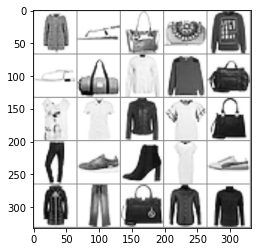

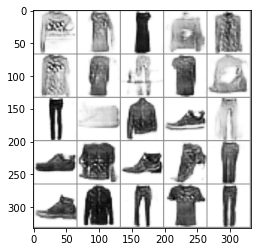

Epochs: 4 Step: 4000 Generator loss: 3.7191711761951445, discriminator loss: 1.0807298066616058


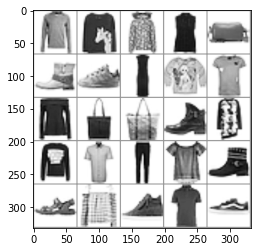

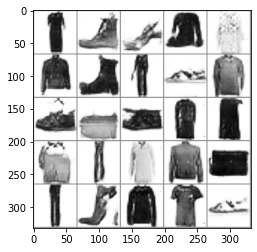

Epochs: 4 Step: 4500 Generator loss: 3.9677559225708245, discriminator loss: 1.0766858586072923


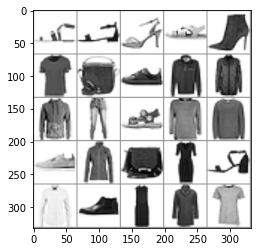

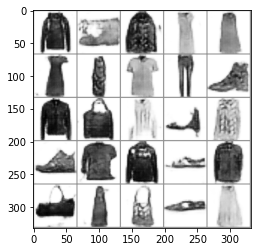

Epochs: 5 Step: 5000 Generator loss: 4.133935620486736, discriminator loss: 1.051846222281456


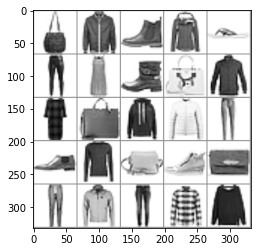

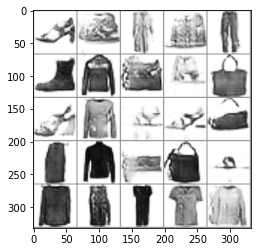

Epochs: 5 Step: 5500 Generator loss: 4.0253458097428085, discriminator loss: 1.071439235806465


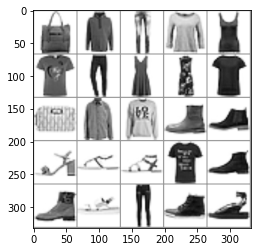

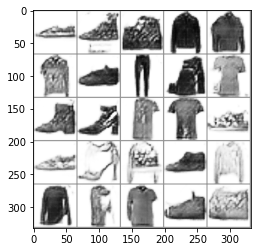

Epochs: 6 Step: 6000 Generator loss: 4.16881472748518, discriminator loss: 1.0665064190626143


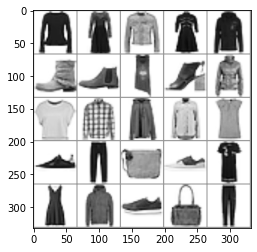

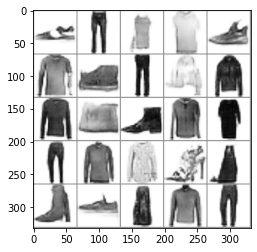

KeyboardInterrupt: 

In [9]:
n_epochs = 100
step = 500
current_step = 0
generator_losses = 0
discriminator_losses = 0
os.makedirs("SGAN", exist_ok=True)

for epoch in range(n_epochs):
    for real, labels in(dataloader):
#         real = real.to(device)
        real_imgs = Variable(real.type(torch.FloatTensor)).to(device)
        labels = Variable(labels.type(torch.LongTensor)).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, len(real)))).to(device)

        
        disc_opt.zero_grad()
        fake_noise = get_noise(len(real), z_dim)
        fake_img = gen(fake_noise)    
        class_preds_fake, disc_preds_fake = disc(fake_img.detach())
        class_preds_fake = class_preds_fake.view(-1, 10)
        disc_preds_fake = disc_preds_fake.view(-1)
        disc_fake_loss = criterion(disc_preds_fake, torch.zeros_like(disc_preds_fake))
        disc_fakeclass_loss = criterion2(class_preds_fake, fake_labels)
        total_fake_loss = (disc_fake_loss + disc_fakeclass_loss) / 2
        
        class_preds_real, disc_preds_real = disc(real_imgs)
        class_preds_real = class_preds_real.view(-1, 10)
        disc_preds_real = disc_preds_real.view(-1)
        disc_real_loss = criterion(disc_preds_real, torch.ones_like(disc_preds_real))
        disc_realclass_loss = criterion2(class_preds_real, labels)
        total_real_loss = (disc_real_loss + disc_realclass_loss) / 2

        disc_loss = (total_fake_loss + total_real_loss ) / 2
        disc_loss.backward()
        disc_opt.step()
        discriminator_losses += disc_loss.item()

        
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(len(real), z_dim)
        fake_labels_2 = Variable(torch.LongTensor(np.random.randint(0, 10, len(real)))).to(device)
        fake_img_2 = gen(fake_noise_2)
        _, disc_preds_fake = disc(fake_img_2)
        disc_preds_fake = disc_preds_fake.view(-1)
        gen_loss = criterion(disc_preds_fake, torch.ones_like(disc_preds_fake))
        gen_loss.backward()
        gen_opt.step()
        
        generator_losses += gen_loss.item()
        
        if current_step % step == 0 and current_step > 0:
            print(f"Epochs: {epoch} Step: {current_step} Generator loss: {generator_losses / step}, discriminator loss: {discriminator_losses / step}")
            img_grid_real = torchvision.utils.make_grid(real_imgs[:25], nrow = 5)
            img_grid_fake = torchvision.utils.make_grid(fake_img[:25], nrow = 5)
            save_image(fake_img_2.data[:36], "SGAN/%d.png" % current_step, nrow=6, normalize=True)
            matplotlib_imshow(img_grid_real, one_channel=True)
            matplotlib_imshow(img_grid_fake,  one_channel=True)
            generator_losses = 0
            discriminator_losses = 0
        current_step += 1